In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr
from scipy.stats import spearmanr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd
from matplotlib.pyplot import rc_context

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, load_df_from_npz
import harmonypy
sys.path.append('../../Code/')
# from utils import TCAT

from sklearn import metrics
from utils import read_dataset_log
import harmonypy as hm
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text

from NMFproj import *

In [2]:
from datashader.mpl_ext import dsshow
import datashader as ds

import matplotlib.colors
cmap_density = plt.cm.hsv
cmaplist = [cmap_density(i) for i in range(cmap_density.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap_density = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap_density.N)

In [3]:
from scipy.stats import fisher_exact

from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


import pickle

## Load programs

In [4]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,activation_score_fn,metadata_fn,Processing notebook path,...,cnmf_dir,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,NaN,...,/data/srlab1/TCAT/Data/PerDataset/AMPRA,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,...,/data/srlab1/TCAT/Data/PerDataset/Pancancer,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,NaN,...,/data/srlab1/TCAT/Data/PerDataset/TBRU,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Analysis/PerDataset/HaoEtAl/...,...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Activ...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,NaN,...,/data/srlab1/TCAT/Data/PerDataset/COMBAT,35.0,0_15,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/

In [5]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))


In [6]:
cgep_params = read_dataset_log('cGEP Paths').iloc[0,:]
cgep_params

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
correlation_matrix_tpm_renorm_varnorm        /data/srlab1/TCAT/Data/TCAT/R.TPMrenorm.VarNor...
correlation_matrix_spectra                   /data

In [7]:
with_singletons = False

In [8]:
if with_singletons:
    ref_fn = cgep_params['tpm_renorm_varnorm_spectra_withsingletons']
    Z_ref_fn = cgep_params['scores_spectra_withsingletons']
else:
    ref_fn = cgep_params['tpm_renorm_varnorm_spectra']
    Z_ref_fn = cgep_params['scores_spectra']
hvg_fn = cgep_params['merged_hvgs']

ref = pd.read_csv(ref_fn, sep='\t', index_col=0)
ref.index = ref.index.map(rename_map)

hvgs = pd.read_csv(hvg_fn, sep='\t', header=None)[0]
ref_hvgs = ref[hvgs].copy()

Z_ref = pd.read_csv(Z_ref_fn, sep='\t', index_col=0)
Z_ref.index = Z_ref.index.map(rename_map)

In [9]:
ref.shape

(52, 12623)

In [10]:
ref_hvgs.shape

(52, 3412)

In [11]:
yasumizu_ref_fn = '../../Data/Misc/Yasumizu_2024_CG/NMF.W.CD4T.csv'
alt_ref = pd.read_csv(yasumizu_ref_fn, index_col = 0).T

In [12]:
yasumizu_labels = ['NMF0 Cytotoxic-F', 'NMF1 Treg-F', 'NMF2 Th17-F', 'NMF3 Naive-F', 
                'NMF4 Act-F', 'NMF5 Th2-F', 'NMF6 Tfh-F', 'NMF7 IFN-F', 'NMF8 Cent. Mem.-F',
                'NMF9 Thymic Emi.-F', 'NMF10 Tissue-F', 'NMF11 Th1-F']


In [13]:
alt_ref.index = yasumizu_labels

In [14]:
alt_ref.head()

,LINC00115,HES4,ISG15,TNFRSF18,TNFRSF4,SMIM1,CA6,SPSB1,AGTRAP,PLOD1,...,AC244090.1,GAB3,RPS4Y1,MT-ND1,MT-ND2,MT-ATP8,MT-ND3,MT-ND4L,MT-ND5,MT-ND6
NMF0 Cytotoxic-F,0.028065,0.000000,0.078505,0.000061,0.000000,0.000000,0.000000,0.000000,0.210299,0.279657,...,0.018772,0.315510,0.020590,0.004504,0.025413,0.079218,0.024246,0.029430,0.100279,0.126834
NMF1 Treg-F,0.022414,0.002400,0.016911,0.094786,0.133513,0.015615,0.000000,0.000000,0.002613,0.003558,...,0.005485,0.000000,0.043842,0.072745,0.064852,0.044015,0.090706,0.070992,0.097093,0.116016
NMF2 Th17-F,0.022533,0.000000,0.070525,0.732933,0.550942,0.003628,0.000000,0.012566,0.000000,0.003086,...,0.009257,0.312372,0.050319,0.064539,0.050463,0.081088,0.000000,0.000000,0.149867,0.145761
NMF3 Naive-F,0.140076,0.062325,0.053799,0.000000,0.000000,0.294294,0.000000,0.002892,0.423793,0.110145,...,0.264092,0.092433,0.992496,0.512497,0.592880,0.381205,0.751455,0.574083,0.442426,0.602868
NMF4 Act-F,0.046632,0.175762,0.166165,0.000000,0.000000,0.103603,0.728803,0.000000,0.000000,0.000000,...,0.036846,0.000000,0.000000,0.169420,0.216246,0.437546,0.236333,0.188078,0.386792,0.373131


In [15]:
alt_ref.min().min()

0.0

In [16]:
alt_ref.shape

(12, 1271)

## Compare programs

In [17]:
overlap = set(ref.columns).intersection(alt_ref.columns)
len(overlap)

1057

In [18]:
R = pd.DataFrame(0, index = ref.index, columns = alt_ref.index)

for i in ref.index:
    for j in alt_ref.index:
        r, _ = pearsonr(ref.loc[i, overlap], alt_ref.loc[j, overlap])
        R.loc[i, j] = r

<AxesSubplot:>

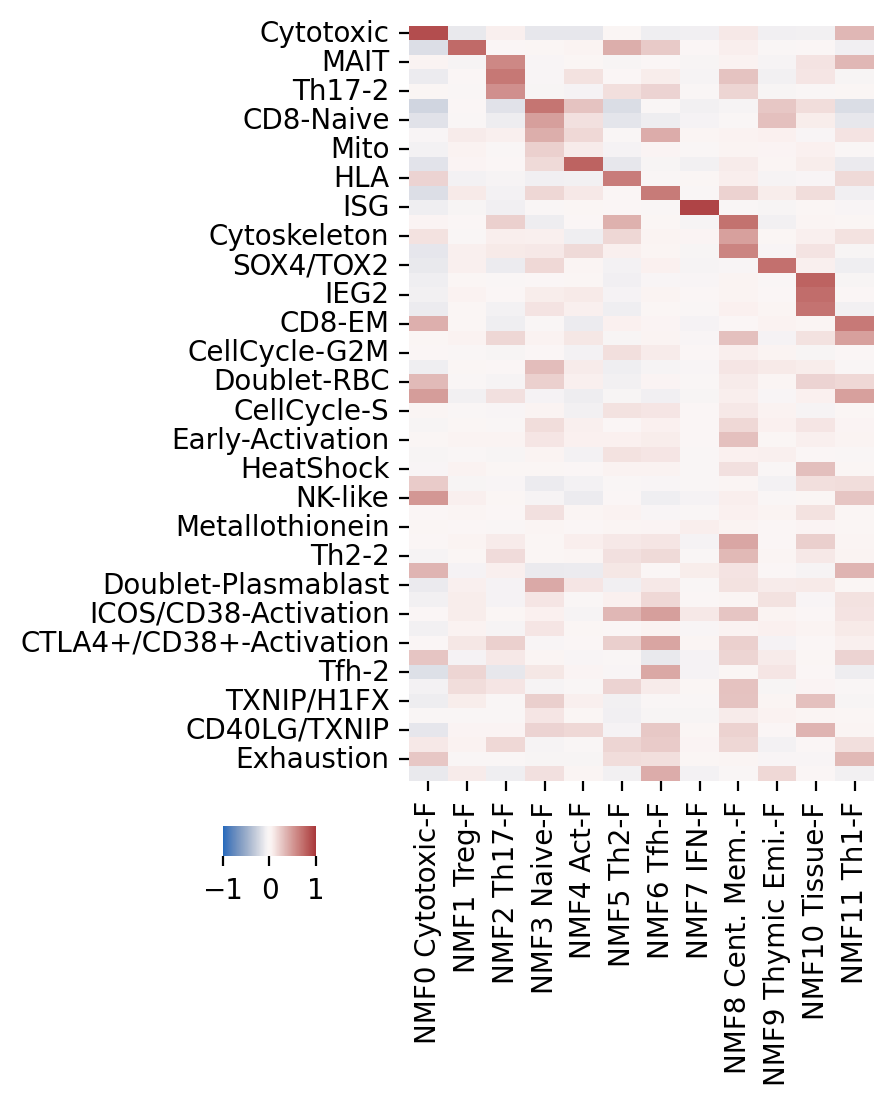

In [19]:
ref_order = ['Cytotoxic',
             'Treg', 
             'MAIT', 'Th17', 'Th17-2',
             'CD4-Naive', 'CD8-Naive', 'MALAT1','Mito',
              'BCL2-Survival',
             'HLA', 
             'CD4-CM', 
             'ISG',
            'CCR10-Migration','Cytoskeleton','Th2-1',
             'SOX4/TOX2',
             'IEG','IEG2', 'YPEL5/JUNB',
            'CD8-EM',  'CD4-EM',
             
             
    'CellCycle-G2M', 'Translation',   'Doublet-RBC',
       'gdT-Blood', 'CellCycle-S', 'Doublet-Platelet',
       'Early-Activation',   'CellCycle-Late-S',
        'HeatShock', 'Multi-Cytokine', 'NK-like',
       'Doublet-Myeloid', 'Metallothionein',  
         'RGCC/MYADM','Th2-2',
       'TIMD4/TIM3-Activation', 'Doublet-Plasmablast',
       'IL10/IL19-Secretion',  'ICOS/CD38-Activation',
       'Doublet-Bcell', 'CTLA4+/CD38+-Activation', 'CD8-Trm-Like',
        'Tfh-2', 'OX40/EBI3-Activation', 'TXNIP/H1FX', 
       'Doublet-Fibroblast',  'CD40LG/TXNIP', 'Tph', 'Exhaustion',
       'Tfh-1']

alt_order = ['NMF0 Cytotoxic-F', 'NMF1 Treg-F', 'NMF2 Th17-F', 'NMF3 Naive-F',
       'NMF4 Act-F', 'NMF5 Th2-F', 'NMF6 Tfh-F', 'NMF7 IFN-F',
       'NMF8 Cent. Mem.-F', 'NMF9 Thymic Emi.-F', 'NMF10 Tissue-F',
       'NMF11 Th1-F']


(fig,ax) = plt.subplots(1,1, figsize=(3,5), dpi=200)
cax = ax.inset_axes([-0.4, -0.1, .2, 0.04], transform=ax.transAxes, zorder=-1)


sns.heatmap(R.loc[ref_order, alt_order], vmin = -1, vmax = 1, cmap = 'vlag', ax=ax, cbar_ax=cax,
           cbar_kws={'orientation':'horizontal', 'ticks':[-1, 0, 1]})

In [20]:
R_Z = pd.DataFrame(0, index = Z_ref.index, columns = alt_ref.index)

for i in Z_ref.index:
    for j in alt_ref.index:
        r, _ = pearsonr(Z_ref.loc[i, overlap], alt_ref.loc[j, overlap])
        R_Z.loc[i, j] = r

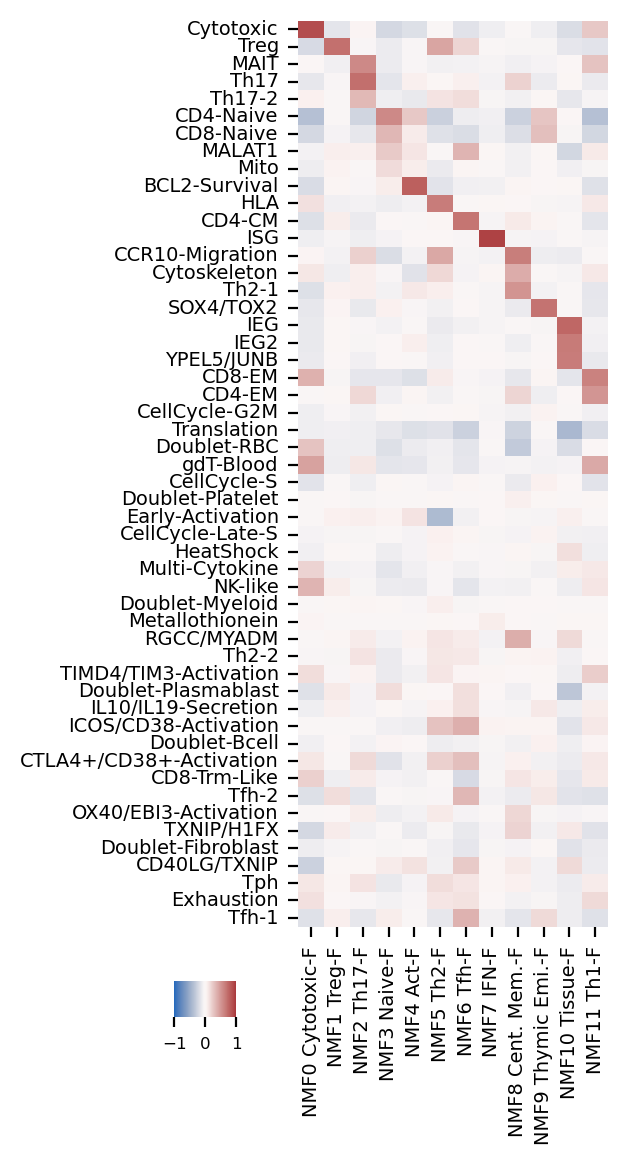

In [21]:
ref_order = ['Cytotoxic',
             'Treg', 
             'MAIT', 'Th17', 'Th17-2',
             'CD4-Naive', 'CD8-Naive', 'MALAT1','Mito',
              'BCL2-Survival',
             'HLA', 
             'CD4-CM', 
             'ISG',
            'CCR10-Migration','Cytoskeleton','Th2-1',
             'SOX4/TOX2',
             'IEG','IEG2', 'YPEL5/JUNB',
            'CD8-EM',  'CD4-EM',
             
             
    'CellCycle-G2M', 'Translation',   'Doublet-RBC',
       'gdT-Blood', 'CellCycle-S', 'Doublet-Platelet',
       'Early-Activation',   'CellCycle-Late-S',
        'HeatShock', 'Multi-Cytokine', 'NK-like',
       'Doublet-Myeloid', 'Metallothionein',  
         'RGCC/MYADM','Th2-2',
       'TIMD4/TIM3-Activation', 'Doublet-Plasmablast',
       'IL10/IL19-Secretion',  'ICOS/CD38-Activation',
       'Doublet-Bcell', 'CTLA4+/CD38+-Activation', 'CD8-Trm-Like',
        'Tfh-2', 'OX40/EBI3-Activation', 'TXNIP/H1FX', 
       'Doublet-Fibroblast',  'CD40LG/TXNIP', 'Tph', 'Exhaustion',
       'Tfh-1']

alt_order = ['NMF0 Cytotoxic-F', 'NMF1 Treg-F', 'NMF2 Th17-F', 'NMF3 Naive-F',
       'NMF4 Act-F', 'NMF5 Th2-F', 'NMF6 Tfh-F', 'NMF7 IFN-F',
       'NMF8 Cent. Mem.-F', 'NMF9 Thymic Emi.-F', 'NMF10 Tissue-F',
       'NMF11 Th1-F']

(fig,ax) = plt.subplots(1,1, figsize=(2,6), dpi=200)
cax = ax.inset_axes([-0.4, -0.1, .2, 0.04], transform=ax.transAxes, zorder=-1)


sns.heatmap(R_Z.loc[ref_order, alt_order], vmin = -1, vmax = 1, cmap = 'vlag', ax=ax, cbar_ax=cax,
           yticklabels=True, xticklabels=True, cbar_kws={'orientation':'horizontal', 'ticks':[-1, 0, 1]})
ax.set_yticklabels(ref_order, fontsize=7)
ax.set_xticklabels(alt_order, fontsize=7)
cax.tick_params(labelsize=6)


## Run NMFproject on Sparks

In [22]:
Sparks_Adata = sc.read(params.loc['Sparks', 'raw_counts_fn'])

In [27]:
Sparks_Adata = Sparks_Adata[:,Sparks_Adata.var['feature_types']=='Gene Expression']

In [30]:
alt_ref

,LINC00115,HES4,ISG15,TNFRSF18,TNFRSF4,SMIM1,CA6,SPSB1,AGTRAP,PLOD1,...,AC244090.1,GAB3,RPS4Y1,MT-ND1,MT-ND2,MT-ATP8,MT-ND3,MT-ND4L,MT-ND5,MT-ND6
NMF0 Cytotoxic-F,0.028065,0.000000,0.078505,0.000061,0.000000,0.000000,0.000000,0.000000,0.210299,0.279657,...,0.018772,0.315510,0.020590,0.004504,0.025413,0.079218,0.024246,0.029430,0.100279,0.126834
NMF1 Treg-F,0.022414,0.002400,0.016911,0.094786,0.133513,0.015615,0.000000,0.000000,0.002613,0.003558,...,0.005485,0.000000,0.043842,0.072745,0.064852,0.044015,0.090706,0.070992,0.097093,0.116016
NMF2 Th17-F,0.022533,0.000000,0.070525,0.732933,0.550942,0.003628,0.000000,0.012566,0.000000,0.003086,...,0.009257,0.312372,0.050319,0.064539,0.050463,0.081088,0.000000,0.000000,0.149867,0.145761
NMF3 Naive-F,0.140076,0.062325,0.053799,0.000000,0.000000,0.294294,0.000000,0.002892,0.423793,0.110145,...,0.264092,0.092433,0.992496,0.512497,0.592880,0.381205,0.751455,0.574083,0.442426,0.602868
NMF4 Act-F,0.046632,0.175762,0.166165,0.000000,0.000000,0.103603,0.728803,0.000000,0.000000,0.000000,...,0.036846,0.000000,0.000000,0.169420,0.216246,0.437546,0.236333,0.188078,0.386792,0.373131
NMF5 Th2-F,0.000000,0.000000,0.208394,0.342539,0.181082,0.000000,0.000000,0.401563,0.192569,0.072251,...,0.064228,0.014037,0.013317,0.000000,0.000000,0.114176,0.000000,0.027931,0.032847,0.069880
NMF6 Tfh-F,0.077666,0.000000,0.147570,0.000000,0.239739,0.000000,0.000000,0.322286,0.000000,0.075865,...,0.000000,0.000000,0.075597,0.041210,0.080234,0.171872,0.000000,0.000000,0.202280,0.315526
NMF7 IFN-F,0.000000,0.409772,1.616325,0.000000,0.034151,0.015384,0.000000,0.062861,0.008856,0.000000,...,0.015672,0.000000,0.000000,0.000000,0.003980,0.117368,0.033841,0.023982,0.122530,0.072850
NMF8 Cent. Mem.-F,0.078949,0.000000,0.118240,0.317724,0.946191,0.058327,0.000000,0.000000,0.397455,0.009807,...,0.074427,0.145977,0.551363,0.281579,0.284995,0.269091,0.358303,0.388821,0.189311,0.124023
NMF9 Thymic Emi.-F,0.032568,0.080368,0.057102,0.000000,0.000000,0.000000,0.036635,0.106009,0.288174,0.012151,...,0.017551,0.011418,0.136290,0.074093,0.082294,0.098145,0.174649,0.120391,0.076328,0.160774


In [79]:
overlap_genes = list(set(alt_ref.columns).intersection(Sparks_Adata.var.index))
len(overlap_genes)

1108

In [32]:
Sparks_X = pd.DataFrame(Sparks_Adata[:,overlap_genes].X.todense(), index=Sparks_Adata.obs.index, columns=overlap_genes)

In [33]:
Sparks_X.head()

,LRRC1,IL7,ZBTB11,ARHGAP10,CENPF,FBLN5,SAMD9L,PREX1,WEE1,CTSW,...,SLA,SH3BGRL3,UBALD2,RGS12,CCDC146,RGMB,GAPDH,TP53INP1,RASSF1,SLC1A4
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
Batch1_COVFLU_CITE_multi5P03_AGGGTGACATTAGGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,7.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
Batch1_COVFLU_CITE_multi5P10_GAACCTACAACGCACC-1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
alt_ref.head()

,LINC00115,HES4,ISG15,TNFRSF18,TNFRSF4,SMIM1,CA6,SPSB1,AGTRAP,PLOD1,...,AC244090.1,GAB3,RPS4Y1,MT-ND1,MT-ND2,MT-ATP8,MT-ND3,MT-ND4L,MT-ND5,MT-ND6
NMF0 Cytotoxic-F,0.028065,0.000000,0.078505,0.000061,0.000000,0.000000,0.000000,0.000000,0.210299,0.279657,...,0.018772,0.315510,0.020590,0.004504,0.025413,0.079218,0.024246,0.029430,0.100279,0.126834
NMF1 Treg-F,0.022414,0.002400,0.016911,0.094786,0.133513,0.015615,0.000000,0.000000,0.002613,0.003558,...,0.005485,0.000000,0.043842,0.072745,0.064852,0.044015,0.090706,0.070992,0.097093,0.116016
NMF2 Th17-F,0.022533,0.000000,0.070525,0.732933,0.550942,0.003628,0.000000,0.012566,0.000000,0.003086,...,0.009257,0.312372,0.050319,0.064539,0.050463,0.081088,0.000000,0.000000,0.149867,0.145761
NMF3 Naive-F,0.140076,0.062325,0.053799,0.000000,0.000000,0.294294,0.000000,0.002892,0.423793,0.110145,...,0.264092,0.092433,0.992496,0.512497,0.592880,0.381205,0.751455,0.574083,0.442426,0.602868
NMF4 Act-F,0.046632,0.175762,0.166165,0.000000,0.000000,0.103603,0.728803,0.000000,0.000000,0.000000,...,0.036846,0.000000,0.000000,0.169420,0.216246,0.437546,0.236333,0.188078,0.386792,0.373131


In [35]:
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(Sparks_X.T, alt_ref.T, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)

In [36]:
df_ev

,ExplainedVariance
NMF0 Cytotoxic-F,0.036041
NMF1 Treg-F,0.001898
NMF2 Th17-F,0.004136
NMF3 Naive-F,0.034897
NMF4 Act-F,0.002901
NMF5 Th2-F,0.003675
NMF6 Tfh-F,0.002427
NMF7 IFN-F,0.000855
NMF8 Cent. Mem.-F,0.044875
NMF9 Thymic Emi.-F,0.003415


In [37]:
df_H.T.to_csv('../../Data/PerDataset/Sparks2023/Yasumizu_NMFproject_Usage_Counts.tsv', sep='\t')

In [38]:
sc.pp.normalize_per_cell(Sparks_Adata, counts_per_cell_after=1e6)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [39]:
Sparks_TPM = pd.DataFrame(Sparks_Adata[:,overlap_genes].X.todense(), index=Sparks_Adata.obs.index, columns=overlap_genes)

In [40]:
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(Sparks_TPM.T, alt_ref.T, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)

In [41]:
df_ev

,ExplainedVariance
NMF0 Cytotoxic-F,0.038024
NMF1 Treg-F,0.002469
NMF2 Th17-F,0.003251
NMF3 Naive-F,0.034628
NMF4 Act-F,0.003422
NMF5 Th2-F,0.002086
NMF6 Tfh-F,0.002512
NMF7 IFN-F,0.000730
NMF8 Cent. Mem.-F,0.035350
NMF9 Thymic Emi.-F,0.002958


In [42]:
df_H.T.to_csv('../../Data/PerDataset/Sparks2023/Yasumizu_NMFproject_Usage_TPM.tsv', sep='\t')

In [43]:
sc.pp.scale(Sparks_Adata, zero_center=False)

In [44]:
Sparks_TPMscale = pd.DataFrame(Sparks_Adata[:,overlap_genes].X.todense(), index=Sparks_Adata.obs.index, columns=overlap_genes)

In [45]:
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(Sparks_TPMscale.T, alt_ref.T, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)

In [46]:
df_ev

,ExplainedVariance
NMF0 Cytotoxic-F,0.035015
NMF1 Treg-F,0.008476
NMF2 Th17-F,0.012791
NMF3 Naive-F,0.039311
NMF4 Act-F,0.012820
NMF5 Th2-F,0.008994
NMF6 Tfh-F,0.019031
NMF7 IFN-F,0.007173
NMF8 Cent. Mem.-F,0.028445
NMF9 Thymic Emi.-F,0.007347


In [47]:
df_H.T.to_csv('../../Data/PerDataset/Sparks2023/Yasumizu_NMFproject_Usage_TPMscale.tsv', sep='\t')

## Run NMFproject on COMBAT

In [69]:
COMBAT_Adata = sc.read(params.loc['COMBAT', 'raw_counts_fn'])

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [70]:
COMBAT_Adata = COMBAT_Adata[:,COMBAT_Adata.var['feature_types']=='Gene Expression']

In [75]:
alt_ref.iloc[:5,:5]

,LINC00115,HES4,ISG15,TNFRSF18,TNFRSF4
NMF0 Cytotoxic-F,0.028065,0.000000,0.078505,0.000061,0.000000
NMF1 Treg-F,0.022414,0.002400,0.016911,0.094786,0.133513
NMF2 Th17-F,0.022533,0.000000,0.070525,0.732933,0.550942
NMF3 Naive-F,0.140076,0.062325,0.053799,0.000000,0.000000
NMF4 Act-F,0.046632,0.175762,0.166165,0.000000,0.000000


In [80]:
overlap_genes = list(set(alt_ref.columns).intersection(COMBAT_Adata.var.index))
len(overlap_genes)

1121

In [81]:
COMBAT_X = pd.DataFrame(COMBAT_Adata[:,overlap_genes].X.todense(), index=COMBAT_Adata.obs.index, columns=overlap_genes)

In [82]:
COMBAT_X.head()

,LRRC1,IL7,ADGRG1,ZBTB11,ARHGAP10,CENPF,FBLN5,SAMD9L,PREX1,WEE1,...,SH3BGRL3,UBALD2,RGS12,CCDC146,RGMB,GAPDH,GRAMD2B,TP53INP1,RASSF1,SLC1A4
AAACCTGAGCGGATCA-1-gPlexA1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
AAACCTGCAGCTCGAC-1-gPlexA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
AAACCTGCATCTATGG-1-gPlexA1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
AAACCTGGTCTCTCTG-1-gPlexA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
AAACCTGTCACCGGGT-1-gPlexA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,2.0,0.0


In [83]:
alt_ref.head()

,LINC00115,HES4,ISG15,TNFRSF18,TNFRSF4,SMIM1,CA6,SPSB1,AGTRAP,PLOD1,...,AC244090.1,GAB3,RPS4Y1,MT-ND1,MT-ND2,MT-ATP8,MT-ND3,MT-ND4L,MT-ND5,MT-ND6
NMF0 Cytotoxic-F,0.028065,0.000000,0.078505,0.000061,0.000000,0.000000,0.000000,0.000000,0.210299,0.279657,...,0.018772,0.315510,0.020590,0.004504,0.025413,0.079218,0.024246,0.029430,0.100279,0.126834
NMF1 Treg-F,0.022414,0.002400,0.016911,0.094786,0.133513,0.015615,0.000000,0.000000,0.002613,0.003558,...,0.005485,0.000000,0.043842,0.072745,0.064852,0.044015,0.090706,0.070992,0.097093,0.116016
NMF2 Th17-F,0.022533,0.000000,0.070525,0.732933,0.550942,0.003628,0.000000,0.012566,0.000000,0.003086,...,0.009257,0.312372,0.050319,0.064539,0.050463,0.081088,0.000000,0.000000,0.149867,0.145761
NMF3 Naive-F,0.140076,0.062325,0.053799,0.000000,0.000000,0.294294,0.000000,0.002892,0.423793,0.110145,...,0.264092,0.092433,0.992496,0.512497,0.592880,0.381205,0.751455,0.574083,0.442426,0.602868
NMF4 Act-F,0.046632,0.175762,0.166165,0.000000,0.000000,0.103603,0.728803,0.000000,0.000000,0.000000,...,0.036846,0.000000,0.000000,0.169420,0.216246,0.437546,0.236333,0.188078,0.386792,0.373131


In [84]:
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(COMBAT_X.T, alt_ref.T, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)

In [85]:
df_ev

,ExplainedVariance
NMF0 Cytotoxic-F,0.035226
NMF1 Treg-F,0.000823
NMF2 Th17-F,0.000641
NMF3 Naive-F,0.005867
NMF4 Act-F,0.000346
NMF5 Th2-F,0.012544
NMF6 Tfh-F,0.000327
NMF7 IFN-F,0.003499
NMF8 Cent. Mem.-F,0.058467
NMF9 Thymic Emi.-F,0.001995


In [86]:
df_H.T.to_csv('../../Data/PerDataset/COMBAT/Yasumizu_NMFproject_Usage_Counts.tsv', sep='\t')

In [87]:
sc.pp.normalize_per_cell(COMBAT_Adata, counts_per_cell_after=1e6)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [88]:
COMBAT_TPM = pd.DataFrame(COMBAT_Adata[:,overlap_genes].X.todense(), index=COMBAT_Adata.obs.index, columns=overlap_genes)


In [89]:
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(COMBAT_TPM.T, alt_ref.T, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)

In [90]:
df_ev

,ExplainedVariance
NMF0 Cytotoxic-F,0.044223
NMF1 Treg-F,0.001405
NMF2 Th17-F,0.000929
NMF3 Naive-F,0.011031
NMF4 Act-F,0.000970
NMF5 Th2-F,0.004318
NMF6 Tfh-F,0.000565
NMF7 IFN-F,0.003826
NMF8 Cent. Mem.-F,0.039935
NMF9 Thymic Emi.-F,0.001731


In [91]:
df_H.T.to_csv('../../Data/PerDataset/COMBAT/Yasumizu_NMFproject_Usage_TPM.tsv', sep='\t')

In [92]:
sc.pp.scale(COMBAT_Adata, zero_center=False)

In [ ]:
COMBAT_TPMscale = pd.DataFrame(COMBAT_Adata[:,overlap_genes].X.todense(), index=COMBAT_Adata.obs.index, columns=overlap_genes)

In [ ]:
X_norm, X_trunc, df_H, fixed_W_trunc = NMFproj(COMBAT_TPMscale.T, alt_ref.T, return_truncated=True, normalized=True)
df_ev = calc_EV(X_trunc, fixed_W_trunc, df_H)

In [ ]:
df_ev

In [ ]:
df_H.T.to_csv('../../Data/PerDataset/COMBAT/Yasumizu_NMFproject_Usage_TPMscale.tsv', sep='\t')